# Linear Searching for Search-by-Image Applications

This searching method serves as a baseline metric of runtime performance where each image in the dataset was compared to the query, for a total of 150x150x3x17,000=1,147,500,000 comparisons. This is expected to be the slowest of each of the candidate set filtering methods, but this baseline shows how much of a performance improvement each of the filtering methods gains, compared to the overhead timecost of preprocessing and filtering.

## Imports

The following functionalities were imported from external packages to assist with the implementations of the Linear Search-by-Image application in order to streamline the development and demonstration process. Below is a list of the imports used, as well as a brief description of why the the package was imported.

* **`os`:** The `os` package was imported for use in iterating over the filesystem in order to extract the relevant filensames and filepaths for the data files during dataset extraction.
* **`math`:** The `math` package is imported for use of its ceiling function (division where the presence of a remainder causes rounding up to the next integer). This ceiling function `ceil` is used in a later cell for displaying the image grid (since that function must work with integer values)
* **`numpy`:** This application uses `numpy.array` as the primary data structure for the data, storing the dataset as an `N` by (`H`x`W`) `numpy` array, where `N` is the number of data files, `H` is the height of the image, and `W` is the width of the image. It was preferred to use `numpy` arrays rather than a `pandas.DataFrame` due to `numpy`'s ability to efficiently reshape the image pixel vectors into the appropriate image dimensions as needed for displaying the image.
* **`matplotlib.pyplot`:** The `pyplot` class of the `matplotlib` package is used for displaying images into the output cells. Rather than saving query results in a separate folder, they are displayed into the output of the relevant cells with the use of the `matplotlib.pyplot`.
* **`time`:** From the `time` package, the `perf_counter` function was imported in order to track runtime performance of the program. One of the metrics used in comparing linear search to the LSH and classification search provided separately is the use of the perf_counter.
* **`PIL`:** From the Python Image Library package, we import the `Image` class, which is used as our primary tool for reading image data into memory and converting the pixel data into `numpy` arrays.
* **`sklearn.metrics.pairwise`:** from this package we extract the `cosine_similarity` function, which is to be used for evaluating the "similarity" score between two image pixel vectors. We chose to use cosine since it is a similarity metric rather than a distance metric. Though we could have handwritten our own cosine similarity function, we decided to use the one provided in `sklearn.metrics.pairwise` in order to improve overall readability, and likely runtime performance. We decided it would be fair to do this since the classification search would also be usilizing `sklearn`.

In [1]:
# === Imports === #
import os
import math
import numpy                  as np
import matplotlib.pyplot      as plt
from time                     import perf_counter
from PIL                      import Image
from sklearn.metrics.pairwise import cosine_similarity

# Setup: Globals and Utility Functions

The next several cells will be used for a combination of setting global variables, defining utility functions, and preparing for dataset extraction. 

## Setup: Defining Initial Globals and Updating Functions

In this cell we define the value of some of the initial globals used for computing the remaining variables needed in the setup. Such values include a `runtimes` array for logging runtime of each cell, and a `data_dir` representing the path to the root of the dataset's directory.

### Utility Function: `update_runtimes( runtimes , label , val , type )`:

We intend to use this function for managing the cataloging of runtimes for the various cells. This function will handle the under-the-hood operations of avoiding double-counting and organizing the given data into the appropriate form

**Input:** This function takes in four required parameters. `runtimes` is the current array of runtime dictinaries of the form `[{'label':label, 'val':val, 'type':type},...]` used for cataloging the runtime performance of each individual cell. The `label` parameter is the label used in the runtime dictionary that is being added/updated. The `val` parameter is the runtime for the entry being added/updated, and the `type` parameter is an integer flag used to distinguis between preprocessing (0), and querying (1). 

**Output:** A copy of the `runtimes` parameter where if an entry with the given `label` exists, the `val` and `type` values are updated witht the given parameters, otherwise, a new dictionary is appended to the `runtimes` list with the appropriate values. 

**Task:** Iterate over the given `runtimes` list. If an entry is encountered with a `label` key that matches the `label` parameter, update that entry's `val` and `type` fields to the given values (this prevents double-counting a cell's runtime if it's rerun). Finally, if no entry with such a `label` exists, construct a new dictionary of the appropriate form to be appended to the end of the list.

In [2]:
# ======================================================================
# FUNCTION: update_runtimes
# ======================================================================
# Input:
#   * runtimes: existing array of runtime dictionaries of the following form
#        [{'label':label_1, 'val':val_1, 'type':type_1}, 
#         ...,
#         {'label':label_n, 'val':val_n, 'type':type_n}]
#   * label: string representing the label key for the dictionary to be
#            added/updated
#   * val: numeric value representing the runtime (val key) of the dictionary
#          to be added/updated
#   * type: numeric (0,1) flag indicating whether the entry is a preprocessing
#           or a querying time (0=preprocessing, 1=querying)
# Output:
#   * an updated version of the runtimes array where if the label already
#     existed, its values are updated, otherwise a new entry is added with 
#     an appropriately formatted dictionary
# Task:
#   1. iterate over runtimes and test if that entry's "label" key matches
#      the given label value
#   2. If an entry exists, update its val and type keys to match the parameters
#   3. If none found during iteration, construct a dictionary of the appropriate
#      form using the given parameters, and append that dictionary to the
#      end of the list
#   4. Return the dictionary upon update or upon append
# ======================================================================
def update_runtimes( runtimes , label , val , type ):
    for i in range(len(runtimes)):
        if runtimes[i]['label'] == label:
            runtimes[i]['val']  = val
            runtimes[i]['type'] = type
            return runtimes
    runtimes.append( { 'label':label , 'val':val , 'type':type } )
    return runtimes


# === Globals Initialization === #
runtimes = list( )  # list to hold and record cell runtimes
L        = 20       # Number of hash strings to make
k        = 20       # Lenght of each hash string
data_dir = 'dataset/intel_images/full'

## Setup: Construct List of Data Directories

The following cell defines a utility function for extracting the names of the data directories, then performing such extraction into a global variable.

### Utility Function: `get_directory_list( data_dir )`:

We intend to use this function for extracting all subdirectory names in the given root data_dir file. The output resutl will be a list of these data subdirectories (each containing the data files).

**Input:** This function takes in one required parameter. `data_dir` is expected to be a string containing the root directory of the data which we will be extracting the subdirectory names of.

**Output:** A list of strings containing the subdirectory names for the given `data_dir`

**Task:** utilize the `os` package to list the contents of the `data_dir`, and return that list with the exclusion of `.DS_Store` and `README`

**Assumptions:**
1. The `data_dir` is the root directory of the data, and each subdirectory of this folder will contain the data files, no further directory branching. Data paths are `data_dir/subdir_found/image_file.jpg`
2. The only contents of `data_dir` are directores, and potentially a `.DS_Store` and a `README` (where the readme has no file type)

In [3]:
# ========================================================
# get_directory_list
# ========================================================
# Input: 
#   - data_dir: string containing absolute or relative path
#               to the root of the data files
# Output:
#   - list containing all subdirectories in the given data_dir
#     except for ".DS_Store" and "README"
# Task:
#   - Iterate over the directory list, and generate a new
#     list of the appropriate subdirectories
# ========================================================
def get_directory_list( data_dir ):
    return [ d for d in os.listdir( data_dir ) if d != '.DS_Store' and d != 'README' ]


# === Extract Directory List and Determine Time-Cost === #
t0       = perf_counter( )
dir_list = get_directory_list( data_dir )
t1       = perf_counter( )
runtimes = update_runtimes( runtimes , 'Directory List Construction' , ( t1 - t0 ) , 0 )


# === Print Results (Not Timed Since Not Necessary) === #
print( 'Directory List:\n' , dir_list )

Directory List:
 ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


## Setup: Constructing List of Data Files

The following cell defines a utility function for extracting the names of each of the data files in the dataset, then performing such extraction into a global variable.

### Utility Function: `get_file_list( data_dir , dir_list )`:

We intend to use this function for extracting all the data file names to be used from the dataset. The list of filenames will be represented in the form of their reachable path from this notebook. (Relative or Absolute pathing depends on whether `data_dir` is defined relatively or absolutely.

**Input:** This function takes in two required parameters. `data_dir` is expected to be a string containing the root directory (the path to it) of the data, and `dir_list` being a list of strings containing the names of the subdirectories where the data image files are stored.

**Output:** A list of strings containing all file names of all subdirectories in `dir_list` of the root directory `data_dir`, including file extensions.

**Task:** utilize the `os` package to list the contents of each of the `data_dir/[dir_list item]`, and return those lists concatenated into a single list

**Assumptions:**
1. The `data_dir` is the root directory of the data, and each subdirectory of this folder will contain the data files, no further directory branching. Data paths are `data_dir/subdir_found/image_file.jpg`
2. The only contents of `data_dir` are directores, and potentially a `.DS_Store` and a `README` (where the readme has no file type)
3. All files within the given `data_dir/subdir_found/` folders are workable, supported image types (.jpg, .png, etc). Note that the images do not need to be the same size, but functionality as expected in future cells cannot be guaranteed, as such cases were not tested.
4. It is assumed that the system is capable of holding the entire dataset in memory at once as a numpy array. The dataset is not reduced, and there is no provided functionality to cut the dataset if the hardware is incapable of holding it in memory. If such functionality was needed, the get_file_list would be modified to extract a random sample of the images from each of the subdirectories instead, but since that functionality was not used on development and test machines, that functionality was excluded from the program.

In [4]:
# ========================================================
# get_file_list
# ========================================================
# Input: 
#   - data_dir: string containing the path to the root directory
#               of the data files
#   - dir_list: list of data subdirectories to use
#   - sample_indices: list/array if ints denoting which pgm files
#                     to use
# Output:
#   - list containing strings. Each being the absolute/relative path
#     to the data files to be used
# Task:
#   - For each directory in the given dir_list, and for each
#     sample index in the given sample_indices, create a filepath
#     by concatenating "data_dir/directory/sample index.pgm"
# ========================================================
def get_file_list( data_dir , dir_list ):
    return [ data_dir + '/' + d + '/' + f 
             for d in dir_list 
             for f in os.listdir( data_dir + '/' + d ) ]


# === Time Construction of File List === #
t0        = perf_counter( )
file_list = get_file_list( data_dir , dir_list )
t1        = perf_counter( )
runtimes  = update_runtimes( runtimes , 'File List Construction' , ( t1 - t0 ) , 0 )


# === Print Output === #
print( 'First 10 in File List:\n' , file_list[:10] )

First 10 in File List:
 ['dataset/intel_images/full/buildings/0.jpg', 'dataset/intel_images/full/buildings/10006.jpg', 'dataset/intel_images/full/buildings/1001.jpg', 'dataset/intel_images/full/buildings/10014.jpg', 'dataset/intel_images/full/buildings/10018.jpg', 'dataset/intel_images/full/buildings/10029.jpg', 'dataset/intel_images/full/buildings/10032.jpg', 'dataset/intel_images/full/buildings/10056.jpg', 'dataset/intel_images/full/buildings/1009.jpg', 'dataset/intel_images/full/buildings/10113.jpg']


## Setup: Extracting the Shape of the Data Images

The following cell defines a utility function for extracting the height and width of the image files (based on the first image present in the file list).

### Utility Function: `get_data_dimensions( file_list )`:

We intend to use this function for extracting the height and width dimensions of the data images. The extraction is based on the first image present in the given `file_list`, and those dimensions will be applied to all images in the files in future cells.

**Input:** This function takes in one required parameter. `file_list` is expected to be a list of the data files (relative or absolute reachable paths).

**Output:** A tuple of the form `(H,W)` where `H` is the height of the first image in the list, and `W` is the list of that image.

**Task:** open the image file using `PIL.Image`, and return the `numpy.shape` of that image.

**Assumptions:**
1. The given `file_list` contains at least one data file (index 0 is valid)
2. The files listed in `file_list` contain valid file paths to existing files that are reachable from this notebook.
3. The `PIL` and `numpy` packages have been imported

In [5]:
# ========================================================
# get_data_dimensions
# ========================================================
# Input: 
#   - file_list: list of all data filepaths
# Output:
#   - Tuple containing the shape of the image, as determined by
#     numpy.shape
# Task:
#   - Open the first image in the file list, and use numpy
#     to compute it's shape
# ========================================================
def get_data_dimensions( file_list ):
    return np.shape( Image.open( file_list[0] ).convert( "L" ) )


# === Call get_data_dimensions With Appropriate Values === #
t0       = perf_counter( )
H , W    = get_data_dimensions( file_list )
t1       = perf_counter( )
runtimes = update_runtimes( runtimes , 'Dimension Extraction' , ( t1 - t0 ) , 0 )

# === Print the Output === #
print( 'Shape = %d x %d => %d Pixels' % ( H , W , H * W ) )

Shape = 150 x 150 => 22500 Pixels


## Setup: Displaying a Grid of Images

The following cell defines a utility function borrowed from Assignment 4 for displaying images in a formatted grids.

### Utility Function: `image_grid( D , H , W , cols=10 , scale=1 )`:

We intend to use this function for displaying sets/subsets of the data in the output of cells, both for final output, and for stepwise demonstration of cell functionality. 

**Input:** This function takes in three required parameters, and two optional parameters. `D` is expected to be the data matrix, where each row of `D` is the pixel-vector of an RGB image (3 data entries per pixel, one for each of the appropriate color channels). `H` and `W` are the respective Height and Width dimensions of the data images. For optional parameters, `cols` is the number of image columns to display in each row of the displayed image grid, and `scale` is the resizing factor (1 = fill to the full space allowed for the given number of columns).

**Output:** No Returs. This function will produce and show a `matplotlib.pyplot` figure in the output cell. The displayed images will be each of the images in the given data array `D` with appropriate dimensions, scaling, and number of columns

**Task:** Iterate over the given data array `D`, and display the RGB image, scaled appropriately, and with the specified shape. 

**Assumptions:**
1. The given H and W are appropriate for the dimensionality of the data (HxWx3=length of each pixel vector)
2. The `math`, `matplotlib.pyplot`, and `numpy` packages have been imported

In [6]:
# ========================================================
# image_grid
# ========================================================
# Input: 
#   - D: array of image vectors
#   - H, W: dimensions of the image
#   - cols: number of images to show on each row
#   - scale: 1 --> fit the screen
# Output:
#   - display the given images in the specified way using
#     inline matplotlib pyplots
# Task:
#   - Iterate over each image in D, and use matplotlib.pyplot
#     to display it as specified
# ========================================================
def image_grid( D , H , W , cols=10 , scale=1 ):
    """ display a grid of images
        H,W: Height and width of the images
        cols: number of columns = number of images in each row
        scale: 1 to fill screen
    """
    n    = np.shape( D )[0]
    rows = int( math.ceil( ( n + 0.0 ) / cols ) )
    fig  = plt.figure( 1 , figsize=[ scale * 20.0/H * W , scale * 20.0/cols * rows ] , dpi=300 )
    for i in range( n ):
        plt.subplot( rows , cols , i + 1 )
        fig = plt.imshow( np.reshape( D[i,:] , [H,W,3] ).astype( int ) )
        plt.axis( 'off' )
    plt.show( )

## Setup (Final): Reading the Data into Memory

The following cell defines a utility function for extracting the image data from each of the data files, and storing the colored pixel vectors as rows in a numpy array (3 entries per pixel, one for each color channel). The cell then demonstrates a successful data read by displaying the first 10 images extracted using `image_grid` defined previously. Please note that the function for reading images into memory operates under the assumption that the entire dataset can fit in memory at once. No schemes or methods were implemented to offload/optimize memory usage, as each of the development and testing machines had sufficient memory for storing the entire dataset in this form in memory.

### Utility Function: `create_images_array( file_list , H , W )`:

We intend to use this function for extracting the image data from the file_list files into a pixel vector of length HxW, and appending that to a row in a numpy array. Note that the function was designed for use when the images are all the same shape. Shape mismatch shouldn't error, but may distort the image in an attempt to fit appropriately -- such conditions were not tested for use in thsi project, since our dataset was defined to be 150x150 for all images in the dataset  

**Input:** This function takes in three required parameters. `file_list` is expected to be the list of strings containing accessible paths to each of the data files to be used. `H` and `W` are the respective Height and Width dimensions of the data images.

**Output:** A numpy array of the shape (N, 3\*H\*W), where N is the number of images considered, and both H and W are the dimensions of the images. Each row contains the RGB pixel vector of the images in the order they appear in `file_list`.

**Task:** Iterate over the given `file_list` array, extract the RGB pixel vector, and store that vector as a row of the array. 

**Assumptions:**
1. The given H and W are appropriate for the dimensionality of the data (HxW=length of each pixel vector)
2. Each filepath specified in `file_list` is a valid file path to an existing image file supported by the Python Image Library.
2. The `PIL.Image`, and `numpy` packages have been imported prior to function use.

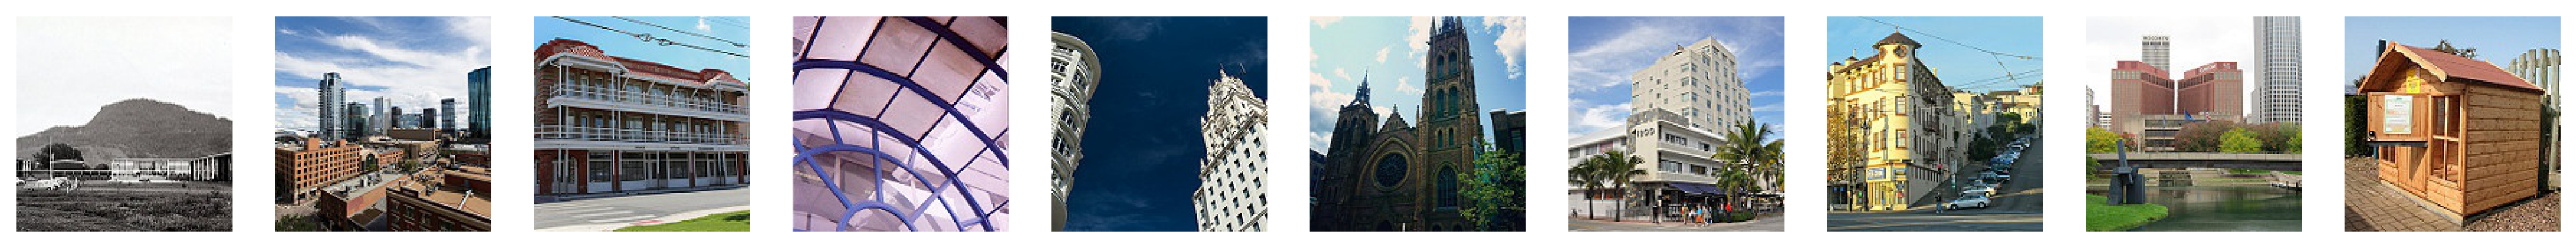

In [7]:
# ========================================================
# create_images_array
# ========================================================
# Input: 
#   - file_list: list of data filepaths to use
#   - H, W: dimensions of the image
# Output:
#   - numpy array containing the extracted image vectors for 
#     each specified image
# Task:
#   - Iterate over the given file list
#   - Open the image file
#   - Resize the image if necessary (if H,W doesn't match)
#     the image's dimensions
#   - Convert into a vecotr, and store as a row in the output
#     array
#   - return the final output array when done iterating
# ========================================================
def create_images_array( file_list , H , W ):
    im_number = len( file_list )
    data      = np.zeros( [ im_number , H * W * 3 ] )
    for i in range( im_number ):
        im = Image.open( file_list[i] ).convert( "RGB" )
        if np.shape( im ) != ( H , W ):
            im = im.resize( ( W , H ) )
        data[i,:] = np.reshape( np.asarray( im ) , [ 1 , H * W * 3 ] )
    return data


# === Call create_images_array On file_list === #
t0   = perf_counter( )
data = create_images_array( file_list , H , W )
t1   = perf_counter( )
runtimes = update_runtimes( runtimes , 'Data Read' , ( t1 - t0 ) , 0 )


# === Show Successful Load by Displaying First 10 in Image Grid === #
image_grid( data[:10] , H , W )

# Query

Preprocessing functions are now complete. The next few cells specify functionality that is performed with each query. One demo is also performed along with the cells using an image of a snowy mountaintop (belonging to the mountain class) of appropriate dimensions (150x150) that does not exist in the full dataset.

## Query: Read the Query Image into Memory

The functionality of this cell is not written as a function, since the demonstration query and label are represented differently from the multiple queries used for average metrics computation later. The `query_image_file` is the absolute or relative path to the query image.

This cell uses the previously defined `create_images_array` where the `file_list` parameter is a list containing only the query image file path. 

Query Image:


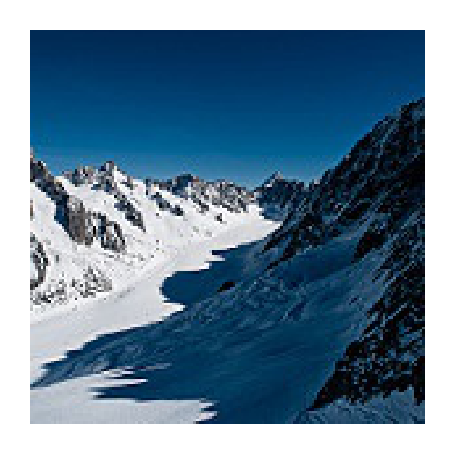

In [8]:
# === Read Into Array === #
t0               = perf_counter( )
query_image_file = 'query/demo.jpg'
query_data       = create_images_array( [ query_image_file ] , H , W ) # get pixel data
t1               = perf_counter( )
runtimes         = update_runtimes( runtimes , 'Extract Query Data' , ( t1 - t0 ) , 1 )


# === Display to Show Success === #
print( 'Query Image:' )
image_grid( query_data , H , W )

## Query: N-Neighbors Linear Search

Now that we have the grayscale image vectors for both the dataset and the query, we perform a linear n-nearest-neighbors search, comparing the query to the datapoints in the dataset. We extract the subset of n-nearest neighbors to the query based on the greatest cosine similarity. If the size of the candidate set is less than the desired number of neighbors, only the candidate set will be reported, but sorted in descending order of cosine similarity to the query. Note that this is the last cell which is timed. This is because all remaining cells evaluate the performance of the linear n-neighbor search, as well as showing the extracted results.

### Query Function: `get_n_neighbors( query_data , candidates , candidate_files ,  num_neighbors )`:

We intend for this function to extract n nearest neighbors to the query by performing a linear search on the candidate set (which is the full dataset for a pure linear search). 

**Input:** This function takes in four required parameters. `query_data` is a numpy array containing the pixel vector of the query image, `candidates` is an array of pixel vectors representing the images in the dataset as extracted in earlier cells, `candidate_files` is the list of filepaths corresponding to the candidates given, and `num_neighbors` is the number of nearest neighbors desired.

**Output:** A tuple of the form `( neighbors , neighbor_candidates , neighbor_files )`, where `neighbors` is a list of `num_neighbors` amount of (index,cosine_similarity_to_query) tuples sorted in descending order of similarity, `neighbor_candidates` is the candidate set filtered to the `num_neighbors` nearest neighbors, and `neighbor_files` is the corresponding filepaths to those neighbors

**Task:** Compute cosine similarity between each candidate and the query, sort in descending order of similarity, slice to keep only the top `num_neighbors`, filter `candidates` and `candidate_files` by the remaining indices, and return the tuple in the appropriate form.

**Assumptions:**
1. `numpy` has already been imported
2. `candidates` has a nonzero length
3. `num_neighbors` is a positive integer

In [9]:
# ========================================================
# get_n_neighbors
# ========================================================
# Input: 
#   - query_data: array of the query's' pixel vector
#   - candidates: set of candidate pixel arrays to be searched
#   - candidate_files: list of filepaths coresponding to the candidates
#   - num_neighbors: positive int representing the number of desired 
#                    nearest neighbors
# Output:
#   - tuple of the form ( neibhors , neighbor_candidates , neighbor_files )
#        neighbors = (candiate_index,cosine_to_query) list of length num_neighbors
#                    sorted by descending cosine
#        neighbor_candidates = candidates filtered to the n-nearest neighbors in
#                              descending order
#        neighbor_files = the corresponding file paths to the neighbor images
# Task:
#   - compute cosine similarity from each candidate to the query
#   - sort by descending order of similarity
#   - filter to keep the num_neighbors most similar candidates
#   - filter candidate_files by the same indices
#   - return the tuple in the appropriate form
# ========================================================
def get_n_neighbors( query_data , candidates , candidate_files , num_neighbors ):
    # === Construct [(candidate_index,similarity)] list === #
    similarities      = np.zeros( ( len( candidates ) , 2 ) , dtype=object )
    similarities[:,0] = [ i for i in range( len( candidates ) ) ]
    similarities[:,1] = cosine_similarity( query_data , candidates )
    
    # === Sort, Slice, and Filter === #
    neighbors           = sorted( similarities , key=lambda x: x[1] , reverse=True )
    neighbors           = neighbors[ : min(num_neighbors , len( neighbors ) ) ]
    neighbor_candidates = candidates[ [ n[0] for n in neighbors ] ]
    neighbor_files      = [ candidate_files[ n[0] ] for n in neighbors ]
    
    # === Return Tuple === #
    return neighbors , neighbor_candidates , neighbor_files


# === Perform Nearest Neighbor Search and Determine Time Cost === #
t0                = perf_counter( )
num_neighbors     = 10
neighbors_results = get_n_neighbors( query_data , data , file_list , num_neighbors)
neighbors , neighbor_candidates , neighbor_files = neighbors_results
t1               = perf_counter( )
runtimes         = update_runtimes( runtimes , 'Query for N Neighbors' , ( t1 - t0 ) , 1 )


# === Display the Neighbor Set === #
print( '%d Nearest Neighbors:' % num_neighbors )
print( neighbors )

10 Nearest Neighbors:
[array([7867, 0.8440224180600023], dtype=object), array([7556, 0.8423846836998474], dtype=object), array([5850, 0.8317118117492149], dtype=object), array([9316, 0.8297922299554216], dtype=object), array([824, 0.828574287877376], dtype=object), array([12664, 0.8270732990325247], dtype=object), array([12825, 0.8242413425117462], dtype=object), array([5438, 0.8238565388069897], dtype=object), array([1909, 0.8218182839174544], dtype=object), array([13513, 0.8189790032920473], dtype=object)]


# Results and Evaluation

Note that all cells starting here are no longer timed. They are used for reporting the performance and showing the results of the prior cells, as well as a brief writeup evaluating them at the end.

## Results: Displaying Nearest Neighbor Files and Scores

This cell shows off the files of the nearest neighbors determined above, and their respective cosine similarieies to the demo query. 

### Display Function: `display_neighbors_metadata( neighbors , candidate_files )`

This function will display the nearest neighbors in order of similarity to the query, and their corresponding similarities

**Input:** This function takes in two required parameters. `neighbors` is a sorted list of tuples of the form (index, cosine to query). `neighbor_files` is a filtered array of strings containing the file paths to the neighbor's files

**Output:** No return, but a formatted print is performed to the cell's output area

**Task:** Iterate over the neighbors and candidates, and print their values in formatted order

**Assumptions:**
1. `neighbor_files` corresponds to `neighbors` with appropriate values and lengths

In [10]:
# ========================================================
# display_neighbor_metadata
# ========================================================
# Input: 
#   - neighbors: list of [(index,cosine)] tupels
#   - neighbor_files: list of filepaths to the corresponding neighbors
# Output:
#   - formatted print of the data in the two lists
# Task:
#   - iterate over the neighbor indices
#   - print the ranking of the neighber (1 is nearest)
#   - print the file of the neighbor indented
#   - print the cosine to query indented
#   - repeat for all neighbors
# ========================================================
def display_neighbors_metadata( neighbors , neighbor_files ):
    for rank in range( len( neighbors ) ):
        print( '%d:' % ( rank + 1 ) )
        print( '\tFile: \"%s\"' % neighbor_files[rank] )
        print( '\tCosine to Query: %.8f\n' % neighbors[rank][1] )
        continue
    return


# === Display the Neighbors Files and Cosines === #
print( 'Neighbors in Descending Order of Similarity:\n' )
display_neighbors_metadata( neighbors , neighbor_files )

Neighbors in Descending Order of Similarity:

1:
	File: "dataset/intel_images/full/glacier/6460.jpg"
	Cosine to Query: 0.84402242

2:
	File: "dataset/intel_images/full/glacier/4159.jpg"
	Cosine to Query: 0.84238468

3:
	File: "dataset/intel_images/full/glacier/13429.jpg"
	Cosine to Query: 0.83171181

4:
	File: "dataset/intel_images/full/mountain/17061.jpg"
	Cosine to Query: 0.82979223

5:
	File: "dataset/intel_images/full/buildings/16538.jpg"
	Cosine to Query: 0.82857429

6:
	File: "dataset/intel_images/full/sea/20520.jpg"
	Cosine to Query: 0.82707330

7:
	File: "dataset/intel_images/full/sea/21756.jpg"
	Cosine to Query: 0.82424134

8:
	File: "dataset/intel_images/full/glacier/10476.jpg"
	Cosine to Query: 0.82385654

9:
	File: "dataset/intel_images/full/buildings/3905.jpg"
	Cosine to Query: 0.82181828

10:
	File: "dataset/intel_images/full/sea/5034.jpg"
	Cosine to Query: 0.81897900



## Results: Display Neighbors on Image Grid

This cell shows off the files of results of the nearest neighbor search by printing both the query image and the neighbors (in order) to show the visual similarity of the neighbors and the query.

### Display Function: `display_query_results_images( query_data , neighbor_candidates , H , W )`

This function will display the image grid of the query and the image grid of the neighbors in the candidate set.

**Input:** This function takes in four required parameters. `query_data` is the pixel vector of the query image. `neighbor_candidates` is the pixel vectors of the nearest neighbors from the candidate set. `H` is the height of the images, and `W` is the width of the images.

**Output:** No return, but a formatted print is performed to show the images

**Task:** call `image_grid` on both the query and neighbors with appropriate scaling and number of columns.

Query:


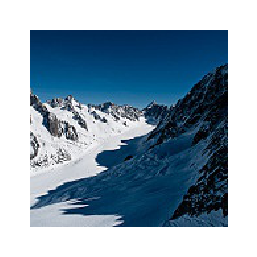

Ordered Neighbors:


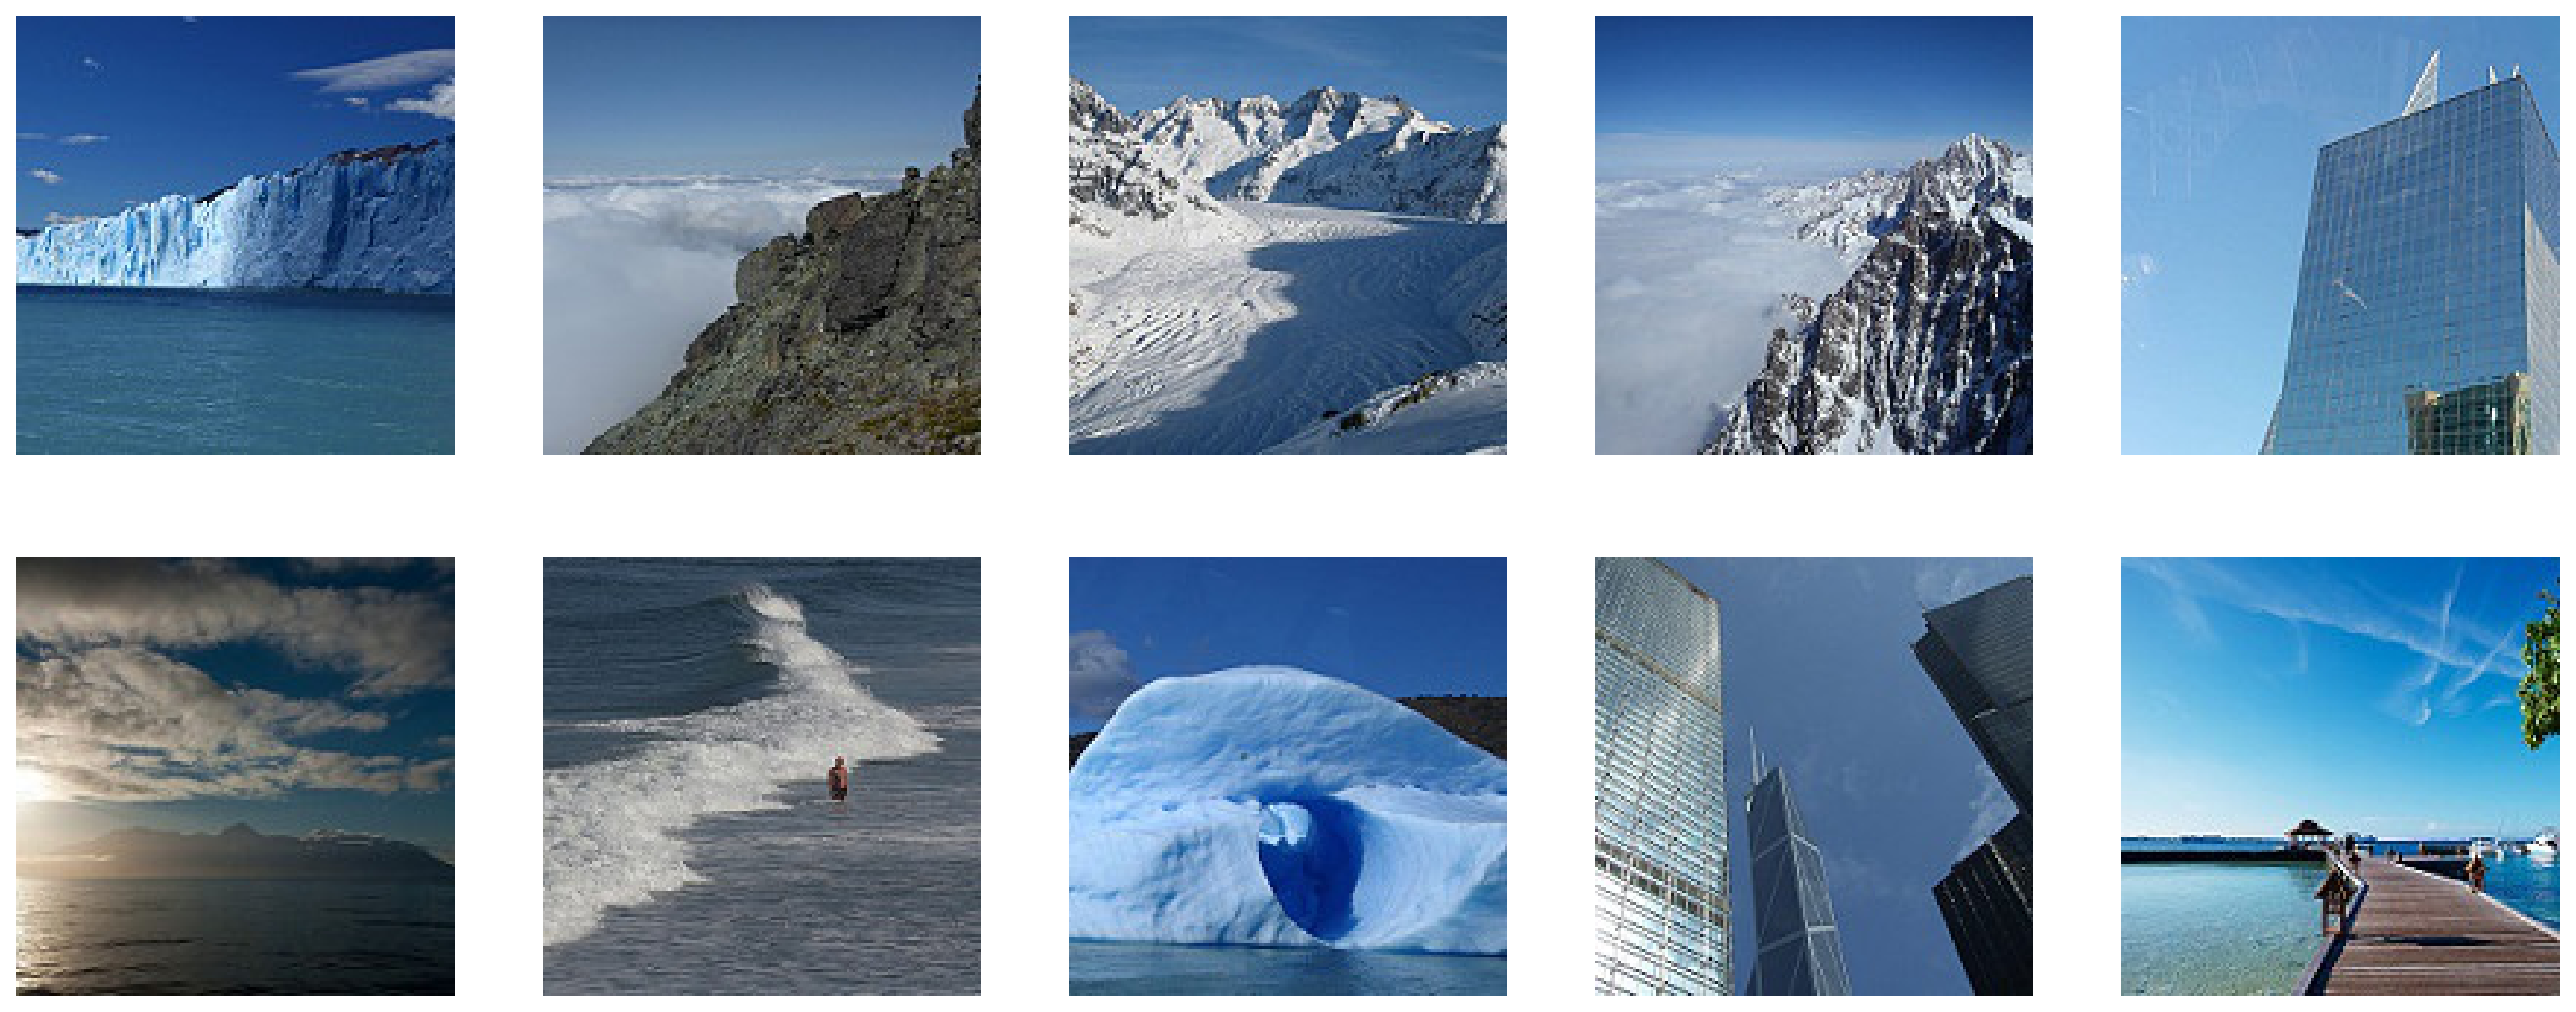

In [11]:
# ========================================================
# display_query_results_images
# ========================================================
# Input: 
#   - query_data: pixel vector of query
#   - neighbor_candidates: pixel vectors of nearest neighbors 
#                          in order
#   - H,W: dimensions of the images
# Output:
#   - formatted print of the data in the two lists
# Task:
#   - display the image grid of the query followed by 
#     the image grid of the candidates with appropriate
#     scaling and number of columns
# ========================================================
def display_query_results_images( query_data , neighbor_candidates , H , W ):
    print( 'Query:' )
    image_grid( query_data , H , W , scale=0.5 )
    print( 'Ordered Neighbors:' )
    image_grid( neighbor_candidates , H , W , cols=5 )
    return


# === Call the Above Function to Display === #
display_query_results_images( query_data , neighbor_candidates , H , W )

## Results: Time Cost

Print the time cost in a formatted way, where each cell's individual time cost is broken down and reported on its own, then the time costs are grouped by type to print, and finally, a total time is reported.

Note that unlike the other two methods, no confusion matrix is produced. This is because no dataset filtering is performed. This means that only runtime performance can be used as a comparison metric to the two filtering schemes.

### Metrics Function: `display_time_costs( runtimes )`

**Input:** the function takes a single input parameter. `runtimes` is expected to be a list of dictionaries, each of the form `{'label':label value, 'val':time cost, 'type': 0 if preprocessing or 1 if query`.

**Output:** No return, rather, a formatted print is performed

**Task:** Iterate over the the runtimes and print with formatting, then print the totals for each type, and the overall total

In [12]:
# ========================================================
# display_time_costs
# ========================================================
# Input: 
#   - runtimes: list of dictionaries with the keys {'label','val','type'}
# Output:
#   - no return, only a formatted print
# Task:
#   - iterate over the runtimes
#   - print each iterated value
#   - print the totals
# ========================================================
def display_time_costs( runtimes ):
    # === Counters === #
    total_time      = 0
    preprocess_time = 0
    query_time      = 0
    
    # === Iteratively Print === #
    print( 'TIME COST BREAKDOWN:' )
    for runtime in runtimes:
        print( '%-27s: %2.8fs' % ( runtime['label'] , runtime['val'] ) )
        total_time += runtime['val']
        if runtime['type'] == 0:
            preprocess_time += runtime['val']
        elif runtime['type'] == 1:
            query_time += runtime['val']
        continue

    # === Print Totals === #
    print( '' )
    print( 'TOTAL TIME COSTS:' )
    print( 'Preprocessing Time (Only Needed Once): %2.8fs' % preprocess_time )
    print( 'Query Time:                            %2.8fs' % query_time )
    print( 'Total Time:                            %2.8fs' % total_time )
    return


# === Call the Above Function === #
display_time_costs( runtimes )

TIME COST BREAKDOWN:
Directory List Construction: 0.00025060s
File List Construction     : 0.01014540s
Dimension Extraction       : 0.01073030s
Data Read                  : 25.86512280s
Extract Query Data         : 0.00208490s
Query for N Neighbors      : 172.43099650s

TOTAL TIME COSTS:
Preprocessing Time (Only Needed Once): 25.88624910s
Query Time:                            172.43308140s
Total Time:                            198.31933050s


## Computing Average Metrics Over Many Queries:

The final task to do for obtaining performance is to query over many times and take the average of the computed metrics in order to more accurately determine performance of the algorithm as a whole. A directory was created with 10 images of each class to be queried one at a time to determine more appropriate average querying metrics, the querying and metrics functions are recreated below without output, solely to achieve performance. Once performance is computed, the averages are printed with formatting. Functions defined in earlier cells are used as much as possible within this cell.

In [13]:
# === Setup: Get Query File Names and Prepare Variables for Use === #
query_dir        = 'query/batch'  # root of the query files
query_dir_list   = get_directory_list( query_dir )  # has a subdirectory for each class
query_file_list  = get_file_list( query_dir , query_dir_list )  # 10 files per subdirectory
query_metrics    = dict( )  # empty metrics dictionary
num_neighbors    = 10  # get 10 nearest neighbors
query_total_time = 0  # clear the timer


# === Query Each Query File One-at-a-Time === #
for query in query_file_list:
    
    # === Perform the Query === #
    query_start_time = perf_counter( )  # Start Timer
    
    # === Preprocessing: Get Class, Read Query Data, Hash Query === #
    query_array      = create_images_array( [query] , H , W )
    
    # === Querying: candidate filtering, n-neighbor searching candidate set === #
    query_neighbors , query_neighbor_candidates , query_neighbor_files = get_n_neighbors( query_array , data , file_list , num_neighbors )
    query_end_time = perf_counter()  # End Timer -- done querying
    
    # === Increment Computation Metrics and Iterate === #
    query_total_time += query_end_time - query_start_time
    continue  # for query
    
    
# === Extract Number of Queries Performed === #
num_queries = len( query_file_list )


# === Formatted Print Average Metrics === #
print( 'Average Query Time for %d Queries:  %2.8fs' % ( num_queries , query_total_time / num_queries ) )

Average Query Time for 60 Queries:  176.41548861s
